<a href="https://colab.research.google.com/github/koya-ken/deep-learning/blob/master/%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0_fashon_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torchvision.models as models
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, Dataset

from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.utils import make_grid, save_image

In [ ]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, *tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [ ]:
train = FashionMNIST('FashionMNIST',train=True, download=True,transform=transforms.ToTensor())
test = FashionMNIST('FashionMNIST',train=False, download=True,transform=transforms.ToTensor())

Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw


Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw


Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw


Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
X_train = train.data.type(torch.float32)
print(X_train.shape)
X_train = X_train.unsqueeze(1).repeat(1,3,1,1)
t_train = train.targets
X_test = test.data.type(torch.float32)
X_test = X_test.unsqueeze(1).repeat(1,3,1,1)
t_test = test.targets

torch.Size([60000, 28, 28])


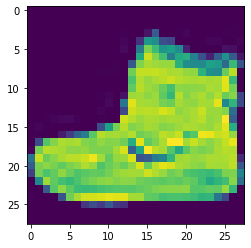

In [ ]:
plt.imshow(X_train[0])

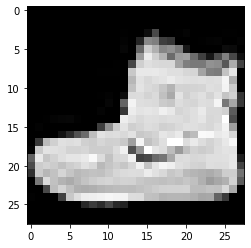

In [ ]:
plt.imshow(X_train[0], cmap='gray')

In [ ]:
X_train[0]

In [ ]:
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

ds_train = TensorDataset(X_train, t_train)
ds_test = TensorDataset(X_test, t_test)

batch_size = 64
loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

In [ ]:
X_train.shape[1:].numel()

784

In [ ]:
n_in = X_train.shape[1:].numel()
n_mid = 128
n_out = 10

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_in, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, n_out),
)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 3, 3),
    nn.ReLU(),
    nn.Conv2d(3, 3, 3),
    nn.ReLU(),
    nn.Conv2d(3, 1, 3),
    nn.Flatten(),
    nn.Linear(484, n_out),
)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
model

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))
  (5): Flatten()
  (6): Linear(in_features=484, out_features=10, bias=True)
)

In [ ]:
F.softmax(model(X_train), dim=1)

tensor([[0.0964, 0.0783, 0.1257,  ..., 0.1233, 0.1325, 0.0802],
        [0.1031, 0.0958, 0.0937,  ..., 0.1024, 0.1021, 0.0913],
        [0.0931, 0.0513, 0.0877,  ..., 0.1180, 0.1259, 0.1234],
        ...,
        [0.1057, 0.0608, 0.0714,  ..., 0.1271, 0.1070, 0.1028],
        [0.1132, 0.0983, 0.0856,  ..., 0.1152, 0.0852, 0.0817],
        [0.1071, 0.0556, 0.1064,  ..., 0.1292, 0.0958, 0.0601]],
       grad_fn=<SoftmaxBackward>)

In [ ]:
loss_fn(model(X_train), t_train)

tensor(2.4158, grad_fn=<NllLossBackward>)

In [ ]:
epoch_count = 10

for epoch in range(epoch_count):
  loss_train = []
  loss_test = []
  train_num = 0
  train_true_num = 0
  test_num = 0
  test_true_num = 0

  model.train()
  for X, t in loader_train:
    X,t = X.to(device), t.to(device)
    optimizer.zero_grad()
    y = model(X)
    loss = loss_fn(y, t)
    loss.backward()
    optimizer.step()

    pred = y.argmax(1)
    loss_train.append(loss.tolist())
    train_num += t.shape[0]
    train_true_num += (pred==t).sum().item()


  model.eval()
  for X, t in loader_train:
    X,t = X.to(device), t.to(device)
    y = model(X)
    loss = loss_fn(y, t)

    pred = y.argmax(1)
    loss_test.append(loss.tolist())
    test_num += t.shape[0]
    test_true_num += (pred==t).sum().item()
  
  print('EPCH {}, Train [Loss: {:.3f}, Accuracy: {:.3f},], Test [Loss: {:.3f}, Accuracy: {:.3f},] '
        .format(epoch,
                np.mean(loss_train),
                train_true_num/ train_num,
                np.mean(loss_test),
                test_true_num/ test_num))

EPCH 0, Train [Loss: 0.654, Accuracy: 0.777,], Test [Loss: 0.506, Accuracy: 0.823,] 
EPCH 1, Train [Loss: 0.491, Accuracy: 0.827,], Test [Loss: 0.461, Accuracy: 0.838,] 
EPCH 2, Train [Loss: 0.462, Accuracy: 0.841,], Test [Loss: 0.451, Accuracy: 0.842,] 
EPCH 3, Train [Loss: 0.447, Accuracy: 0.845,], Test [Loss: 0.428, Accuracy: 0.849,] 
EPCH 4, Train [Loss: 0.436, Accuracy: 0.849,], Test [Loss: 0.414, Accuracy: 0.857,] 
EPCH 5, Train [Loss: 0.427, Accuracy: 0.851,], Test [Loss: 0.408, Accuracy: 0.859,] 
EPCH 6, Train [Loss: 0.420, Accuracy: 0.855,], Test [Loss: 0.418, Accuracy: 0.853,] 
EPCH 7, Train [Loss: 0.414, Accuracy: 0.857,], Test [Loss: 0.409, Accuracy: 0.854,] 
EPCH 8, Train [Loss: 0.411, Accuracy: 0.857,], Test [Loss: 0.403, Accuracy: 0.857,] 
EPCH 9, Train [Loss: 0.408, Accuracy: 0.858,], Test [Loss: 0.389, Accuracy: 0.863,] 


In [ ]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 4.0MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5269 sha256=da345fa0e20f78708d36ad5853bc95725fd65cf59fd9726fd5943dc0391c8495
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [ ]:
# Grad-CAM
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [ ]:
X_train[:10].shape

torch.Size([10, 3, 28, 28])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


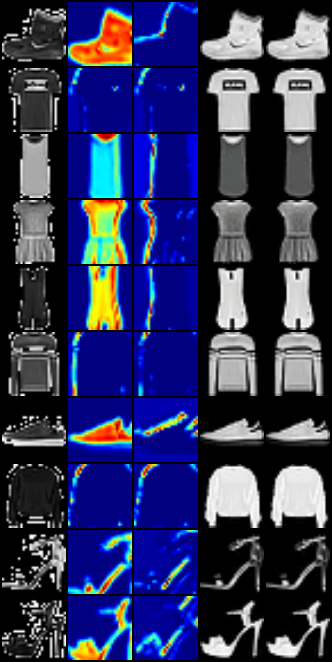

In [ ]:
target_layer = model[2]

gradcam = GradCAM(model, target_layer)
gradcam_pp = GradCAMpp(model, target_layer)

images = []
for torch_img in X_train[:10]:
  trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64,64)),
    transforms.ToTensor()
  ])
  normed_torch_img = torch_img.unsqueeze(0).to(device)
  mask, _ = gradcam(normed_torch_img)
  heatmap, result = visualize_cam(mask, torch_img)

  mask_pp, _ = gradcam_pp(normed_torch_img)
  heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

  images.extend([trans(torch_img).cpu(), trans(heatmap), trans(heatmap_pp), trans(result), trans(result_pp)])

grid_image = make_grid(images, nrow=5)
grid_image = transforms.ToPILImage()(grid_image)
grid_image

In [ ]:
model_ft = models.resnet18(pretrained=True)
# 重みを固定
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.conv1 = nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model_ft.fc = nn.Linear(512,10)
model_ft.to(device)
optimizer_ft = optim.Adam(model_ft.parameters())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
 models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
model_ft = models.mnasnet0_5(pretrained=True)
# 重みを固定
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.layers[0] = nn.Conv2d(1,16,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model_ft.classifier[1] = nn.Linear(1280,10)
model_ft.to(device)
optimizer_ft = optim.Adam(model_ft.parameters())

In [ ]:
model_ft = models.mobilenet_v2(pretrained=True)
# 重みを固定
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.features[0] = nn.Conv2d(1,32,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model_ft.classifier[1] = nn.Linear(1280,10)
model_ft.to(device)
optimizer_ft = optim.Adam(model_ft.parameters())

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
for module in model_ft.modules():
    if hasattr(module, 'weight'):
      prune.random_unstructured(module, name="weight", amount=0.8)
      prune.remove(module, 'weight')

In [ ]:
for module in model_ft.modules():
  if hasattr(module, 'bias') and module.bias is not None:
      prune.random_unstructured(module, name="bias", amount=0.8)
      prune.remove(module, 'bias')

In [ ]:
epoch_count = 10

for epoch in range(epoch_count):
  loss_train = []
  loss_test = []
  train_num = 0
  train_true_num = 0
  test_num = 0
  test_true_num = 0

  model_ft.train()
  for X, t in loader_train:
    X,t = X.to(device), t.to(device)
    X = X[:,None,:,:]
    optimizer_ft.zero_grad()
    y = model_ft(X)
    loss = loss_fn(y, t)
    loss.backward()
    optimizer_ft.step()

    pred = y.argmax(1)
    loss_train.append(loss.tolist())
    train_num += t.shape[0]
    train_true_num += (pred==t).sum().item()


  model_ft.eval()
  for X, t in loader_train:
    X,t = X.to(device), t.to(device)
    X = X[:,None,:,:]
    y = model_ft(X)
    loss = loss_fn(y, t)

    pred = y.argmax(1)
    loss_test.append(loss.tolist())
    test_num += t.shape[0]
    test_true_num += (pred==t).sum().item()
  
  print('EPCH {}, Train [Loss: {:.3f}, Accuracy: {:.3f},], Test [Loss: {:.3f}, Accuracy: {:.3f},] '
        .format(epoch,
                np.mean(loss_train),
                train_true_num/ train_num,
                np.mean(loss_test),
                test_true_num/ test_num))

EPCH 0, Train [Loss: 1.084, Accuracy: 0.630,], Test [Loss: 0.792, Accuracy: 0.728,] 
EPCH 1, Train [Loss: 0.889, Accuracy: 0.694,], Test [Loss: 0.721, Accuracy: 0.750,] 
EPCH 2, Train [Loss: 0.844, Accuracy: 0.711,], Test [Loss: 0.691, Accuracy: 0.759,] 
EPCH 3, Train [Loss: 0.817, Accuracy: 0.719,], Test [Loss: 0.668, Accuracy: 0.769,] 
EPCH 4, Train [Loss: 0.782, Accuracy: 0.729,], Test [Loss: 0.638, Accuracy: 0.780,] 
EPCH 5, Train [Loss: 0.783, Accuracy: 0.730,], Test [Loss: 0.676, Accuracy: 0.759,] 
EPCH 6, Train [Loss: 0.798, Accuracy: 0.724,], Test [Loss: 0.642, Accuracy: 0.776,] 
EPCH 7, Train [Loss: 0.753, Accuracy: 0.736,], Test [Loss: 0.625, Accuracy: 0.781,] 
EPCH 8, Train [Loss: 0.754, Accuracy: 0.739,], Test [Loss: 0.613, Accuracy: 0.782,] 
EPCH 9, Train [Loss: 0.733, Accuracy: 0.745,], Test [Loss: 0.612, Accuracy: 0.783,] 


In [ ]:
torch.save(model_ft.state_dict(), 'mobilenet_v2_3.pth')

In [ ]:
models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
a = nn.Conv2d(1,3,3)

In [ ]:
dir(a)

['__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_conv_forward',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_reversed_padding_repeated_twice',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'bias',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'dilation',
 'dou

In [ ]:
a.in_channels = 3

In [ ]:
a

Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))